In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'
# tables = pd.read_html(url)

# ftse100_df = tables[6]
# tickers = ftse100_df['Ticker'].tolist()
# tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

In [4]:
import pandas as pd
import requests

url = 'https://en.wikipedia.org/wiki/FTSE_100_Index'

# Define a User-Agent header to mimic a web browser
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.60 Safari/537.36'
}

# Make the request with the headers
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # This will raise an HTTPError for bad responses (4xx or 5xx)
    
    # Pass the content of the response to pandas
    tables = pd.read_html(response.text)
    
    ftse100_df = tables[6]
    tickers = ftse100_df['Ticker'].tolist()
    tickers = [ticker + '.L' for ticker in tickers]  # Yahoo Finance suffix for London Stock Exchange

    print(f"Number of tickers found: {len(tickers)}")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

Number of tickers found: 100


In [5]:
# Fetch historical data (e.g., 5 years of daily data)
data = yf.download(tickers, start="2020-01-01", end="2024-12-31", group_by='ticker')

[*********************100%***********************]  100 of 100 completed


In [6]:
data.head()

Ticker           RTO.L                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2020-01-02  453.703550  458.299540  452.904230  455.202240  1981730   
2020-01-03  451.905036  458.699117  449.307331  457.500153  1768294   
2020-01-06  451.905082  459.380574  448.707894  452.104919  2304051   
2020-01-07  444.811337  447.658825  433.321377  442.013763  7707219   
2020-01-08  440.914678  446.010231  437.118008  445.111023  3683135   

Ticker            ABF.L                                                  ...  \
Price              Open         High          Low        Close   Volume  ...   
Date                                                                     ...   
2020-01-02  2589.455015  2610.434395  2571.472688  2577.466797   719185  ...   
2020-01-03  2561.482333  2607.437165  2561.482333  2590.453857  1596780  ...   
2020-01-06  2570.473612  2622.422554  2558.485395  2612.432373   878617  ...   
2020-01-07  2621.423115  2701.614305  2613.430971  2669.375977  1338980  ...   
2020-01-08  2666.379357  2690.355792  2646.847529  2659.386230  1048965  ...   

Ticker            GAW.L                                                 \
Price              Open         High          Low        Close  Volume   
Date                                                                     
2020-01-02  6152.890987  6163.245609  5963.264176  6053.087402   42961   
2020-01-03  6043.107168  6152.891113  6018.156271  6152.891113   81512   
2020-01-06  6212.773926  6302.447555  6093.009609  6212.773926   51019   
2020-01-07  6212.772474  6297.605512  6192.811759  6257.684082  150089   
2020-01-08  6227.744684  6348.223419  6207.783964  6277.646484   50121   

Ticker           BNZL.L                                                  
Price              Open         High          Low        Close   Volume  
Date                                                                     
2020-01-02  2083.349421  2101.326549  2078.355774  2089.341797   728124  
2020-01-03  2071.364526  2097.331487  2056.383587  2091.339111   542500  
2020-01-06  2075.359608  2087.344360  2056.383750  2065.372314   483488  
2020-01-07  2078.355233  2082.350150  2046.395903  2049.392090   519568  
2020-01-08  2037.407948  2041.402866  2019.430819  2027.420654  1333170  

[5 rows x 500 columns]

In [7]:
# Step 1: Calculate Mid prices for each ticker
mid_prices = pd.concat([
    ((data[ticker]['Open'] + data[ticker]['Close']) / 2).rename(ticker)
    for ticker in tickers
], axis=1)

# Step 2: Drop rows with missing values (optional)
mid_prices = mid_prices.dropna()

In [8]:
mid_prices.head()

,III.L,ADM.L,AAF.L,ALW.L,AAL.L,ANTO.L,AHT.L,ABF.L,AZN.L,AUTO.L,...,STJ.L,TW.L,TSCO.L,ULVR.L,UU.L,UTG.L,VOD.L,WEIR.L,WTB.L,WPP.L
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-18,1193.615936,1770.288260,158.555075,930.802038,2574.943961,1028.609801,3871.105040,1611.763859,11140.145001,584.318380,...,1151.496766,118.416251,259.682220,3875.865826,1026.843683,1151.705520,129.199156,1385.705290,2643.169015,805.614169
2022-07-19,1189.619075,1732.080647,162.050759,929.303080,2552.169888,1029.859072,3887.594268,1639.992147,11113.164148,586.617211,...,1154.743272,119.438799,260.281481,3891.598508,1044.818920,1155.201584,130.067017,1392.201491,2647.665493,820.790009
2022-07-20,1200.361113,1734.578044,163.998356,942.793028,2583.270673,1053.344424,4023.010463,1673.716288,11072.193479,597.711911,...,1164.982076,121.334250,261.230313,3911.575085,1051.060183,1166.189236,130.096950,1414.438670,2689.628375,851.041690
2022-07-21,1223.593920,1744.566764,165.945963,952.785510,2563.434437,1043.350499,4103.460869,1692.451994,10782.395397,609.006414,...,1171.225501,124.177437,260.081712,3888.601682,1057.301904,1170.184765,128.690434,1465.159637,2679.137371,863.821265
2022-07-22,1244.578427,1741.819848,165.496514,953.285163,2591.841027,1064.087686,4159.926540,1692.951760,10762.410267,613.304445,...,1182.713001,125.474332,259.831999,3906.581131,1066.788776,1196.655002,128.750296,1492.144176,2674.142020,864.919578


In [9]:
# Step 3: Transpose so that each row is a ticker and columns are dates
data_for_clustering = mid_prices.T.copy()

# Calculate percentage difference with respect to the first column (first date)
df_pct_diff = ((data_for_clustering.T - data_for_clustering.T.iloc[0]) / data_for_clustering.T.iloc[0]) * 100

# Transpose back to original format: Tickers as rows, Dates as columns
df_pct_diff = df_pct_diff.T

# Optional: round values for better readability
df_pct_diff = df_pct_diff.round(2)

In [10]:
df_pct_diff.head()

Date,2022-07-18,2022-07-19,2022-07-20,2022-07-21,2022-07-22,2022-07-25,2022-07-26,2022-07-27,2022-07-28,2022-07-29,...,2024-12-10,2024-12-12,2024-12-13,2024-12-18,2024-12-19,2024-12-20,2024-12-23,2024-12-24,2024-12-27,2024-12-30
III.L,0.0,-0.33,0.57,2.51,4.27,2.80,1.67,1.72,3.83,5.76,...,204.51,204.30,204.88,205.01,198.64,196.38,196.59,199.56,201.28,199.94
ADM.L,0.0,-2.16,-2.02,-1.45,-1.61,-2.09,-0.63,1.88,4.97,7.41,...,50.81,49.51,49.12,47.53,47.08,46.63,47.17,48.33,47.99,47.68
AAF.L,0.0,2.20,3.43,4.66,4.38,4.98,7.43,8.16,4.35,-0.09,...,-32.90,-33.06,-32.53,-32.94,-33.85,-33.98,-32.37,-30.38,-29.06,-28.49
ALW.L,0.0,-0.16,1.29,2.36,2.42,2.84,1.23,1.61,3.27,4.29,...,37.39,37.39,37.60,34.59,33.52,33.95,34.27,34.49,33.41,33.73
AAL.L,0.0,-0.88,0.32,-0.45,0.66,2.32,4.80,4.99,8.17,11.15,...,-4.68,-3.24,-5.19,-7.63,-10.23,-11.23,-11.19,-10.10,-10.73,-11.17


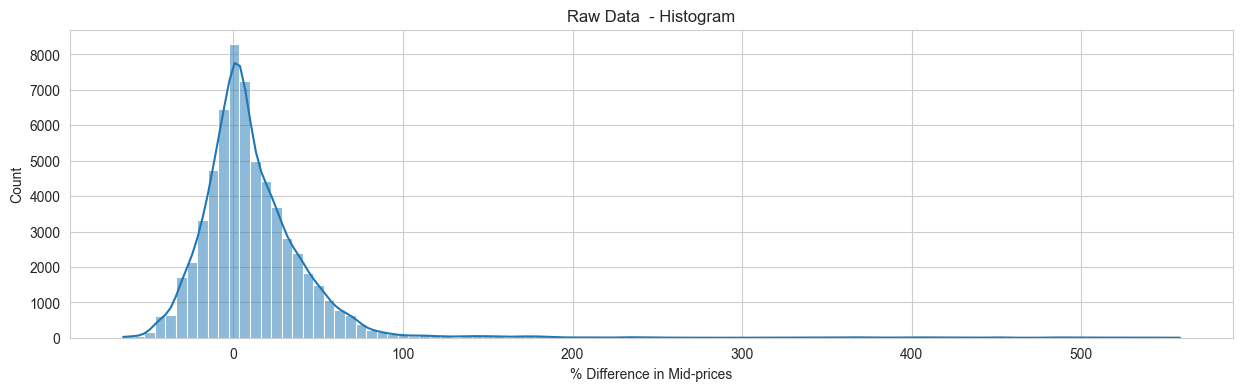

In [11]:
plt.figure(figsize=(15, 4))
sns.histplot(df_pct_diff.values.flatten(), bins=100, kde=True)
plt.title(f'{"Raw Data"}  - Histogram')
plt.xlabel("% Difference in Mid-prices")
plt.show()

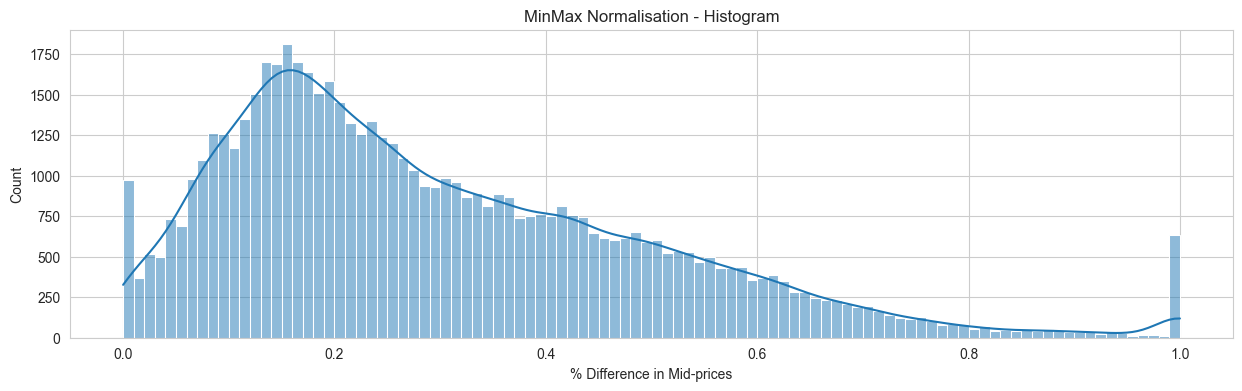

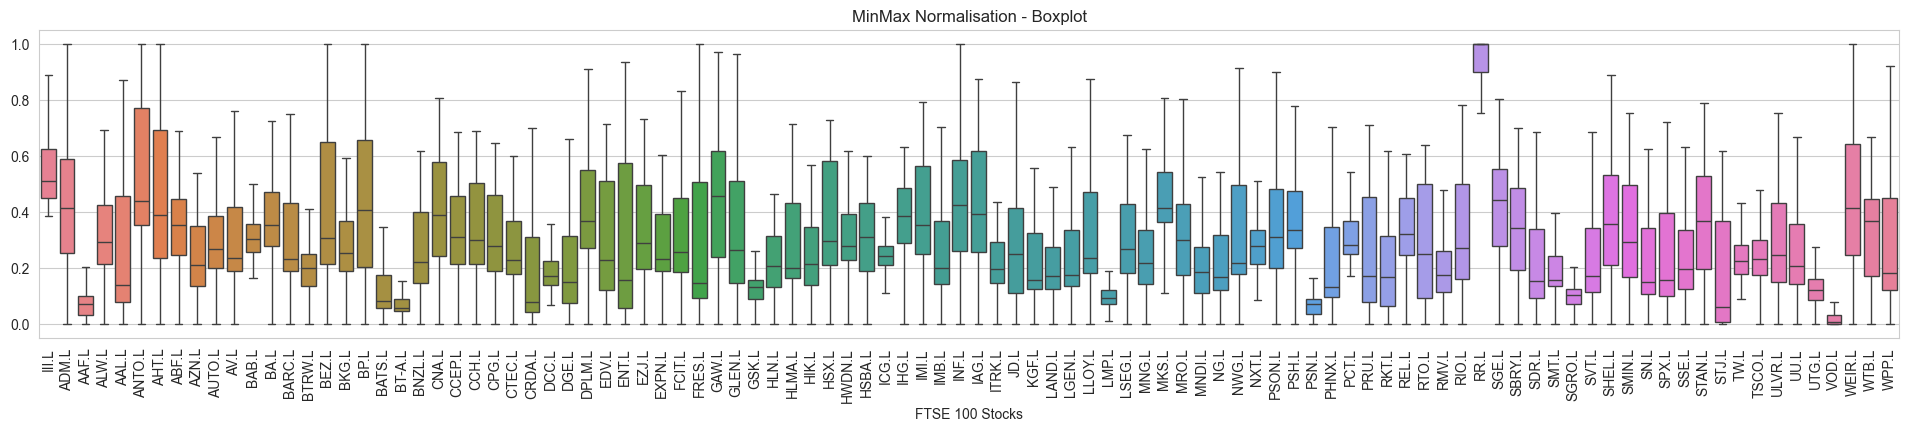

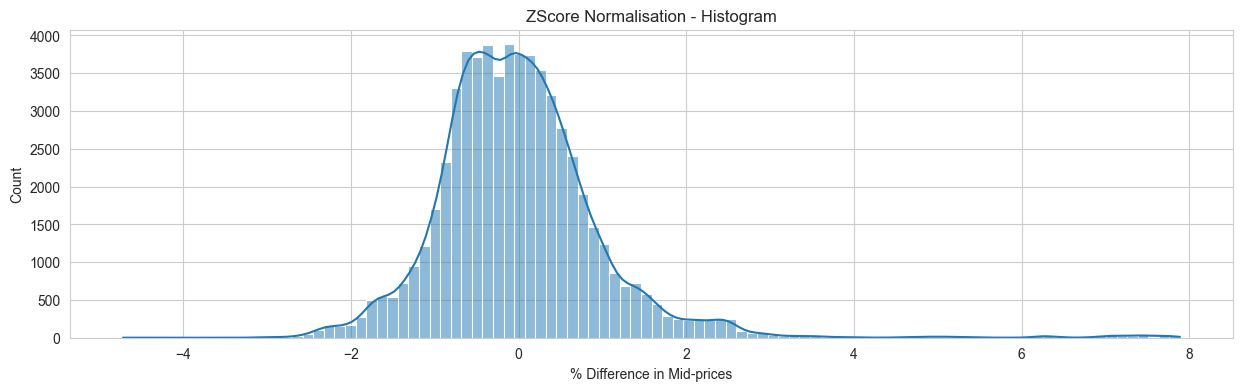

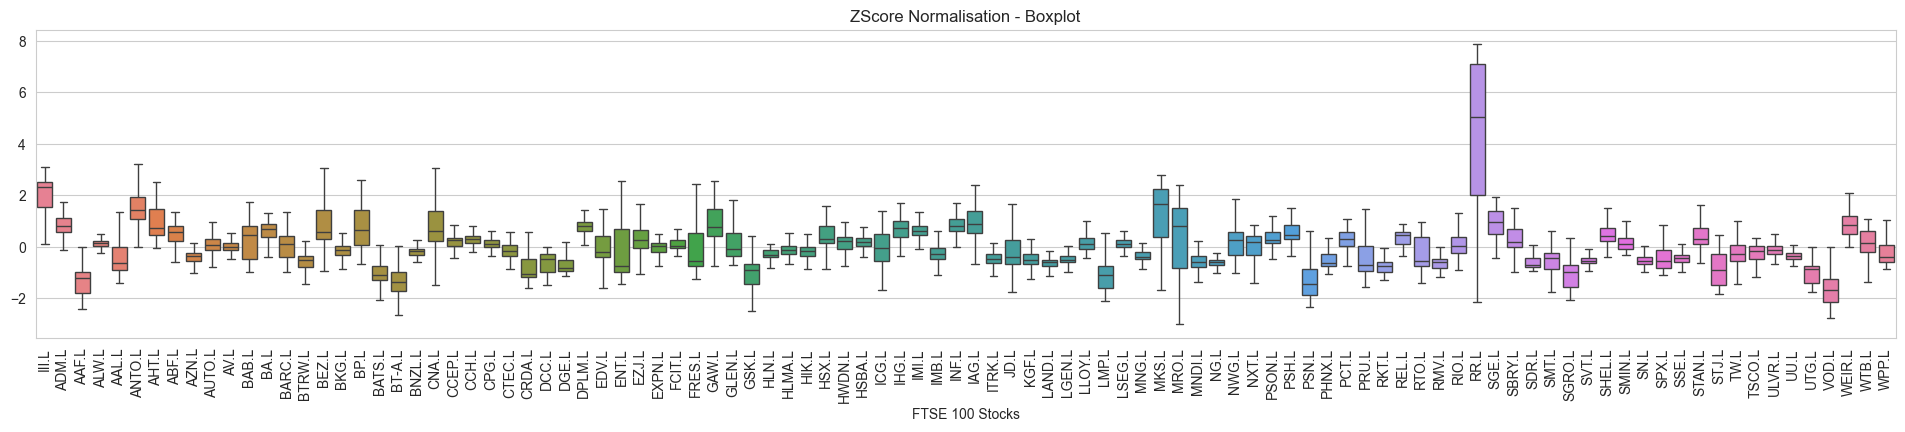

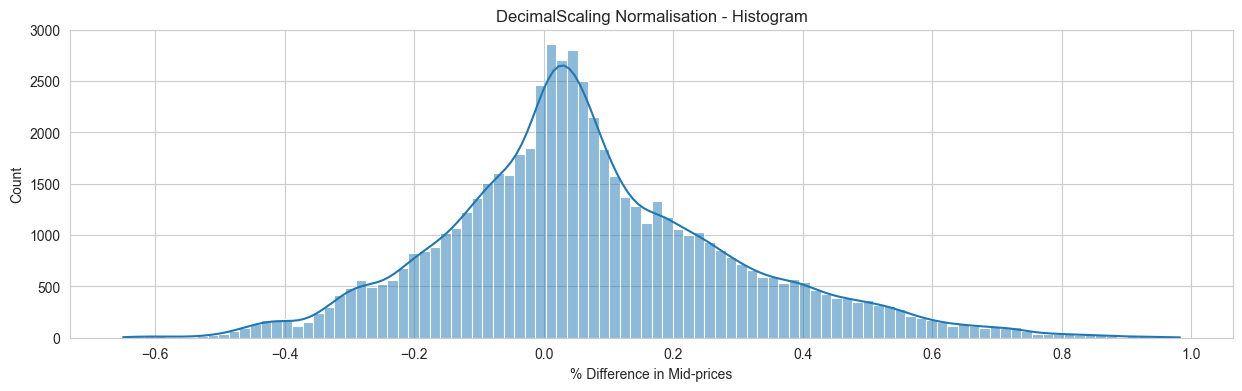

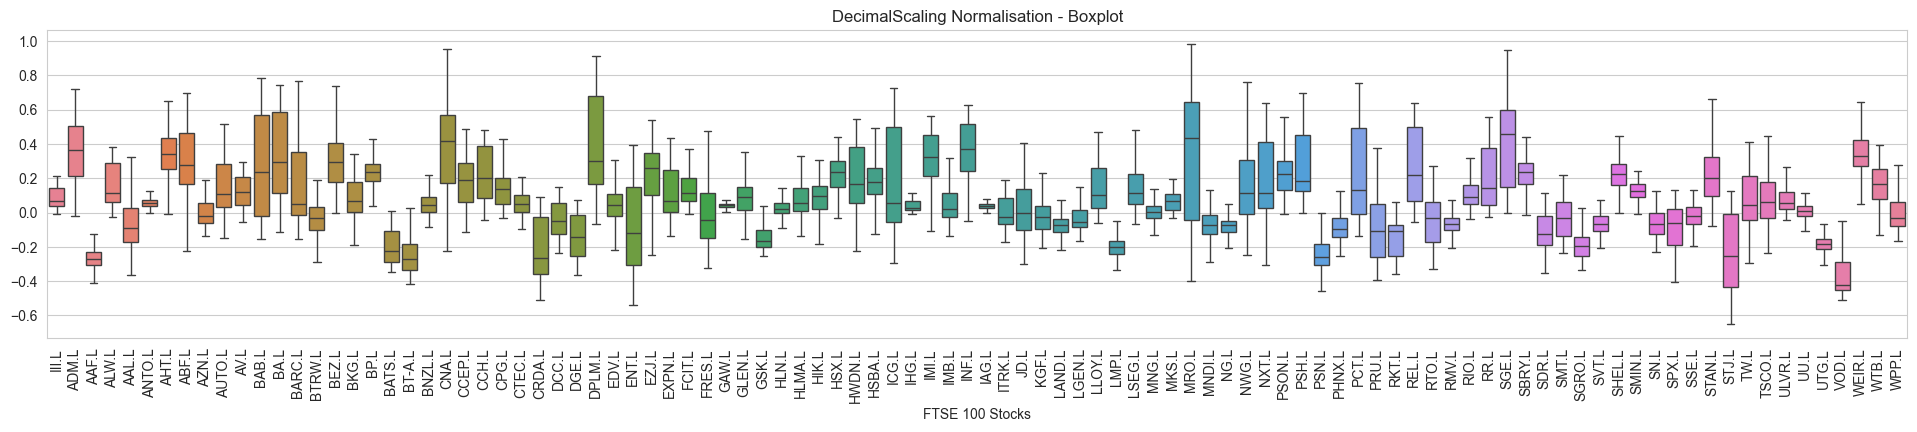

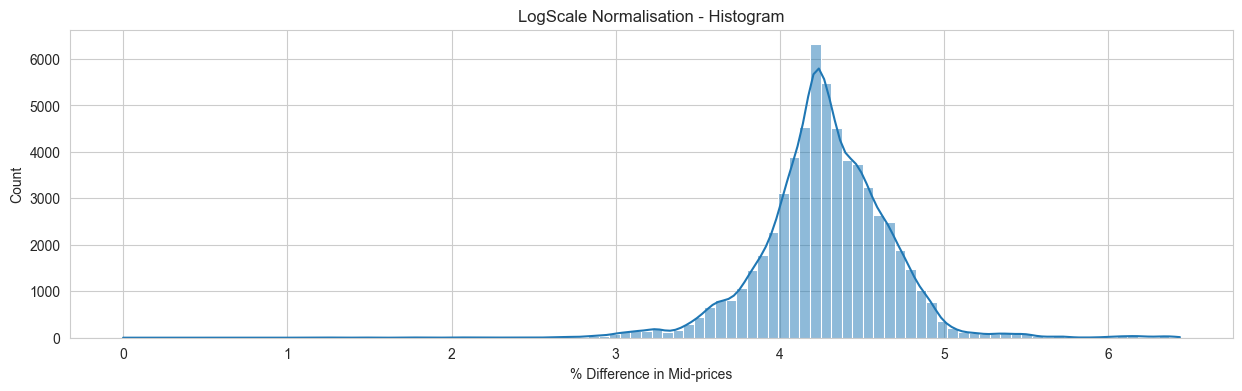

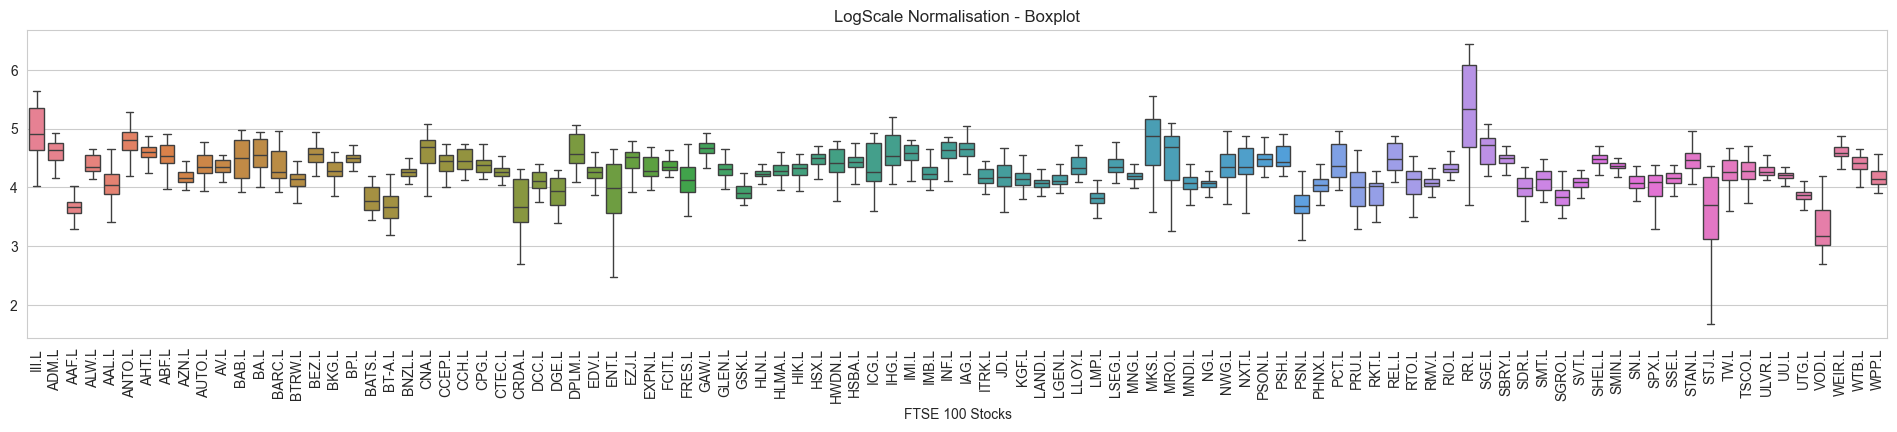

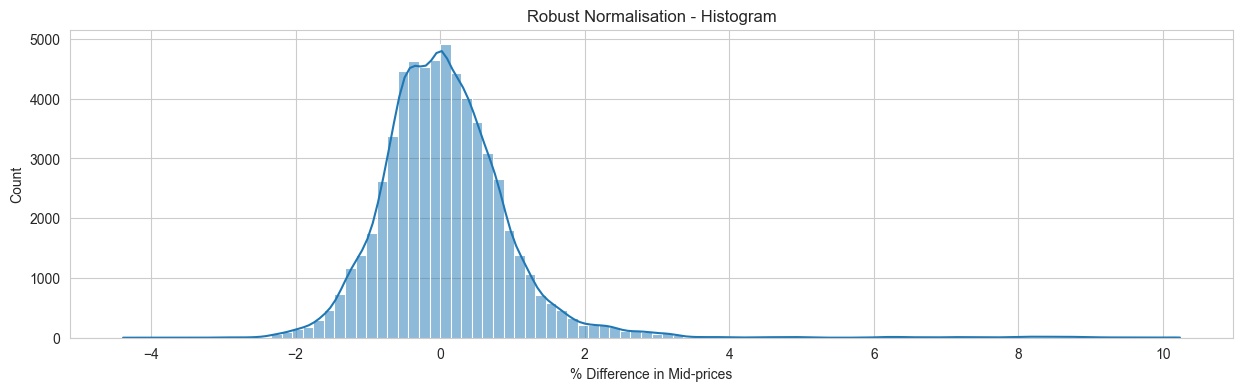

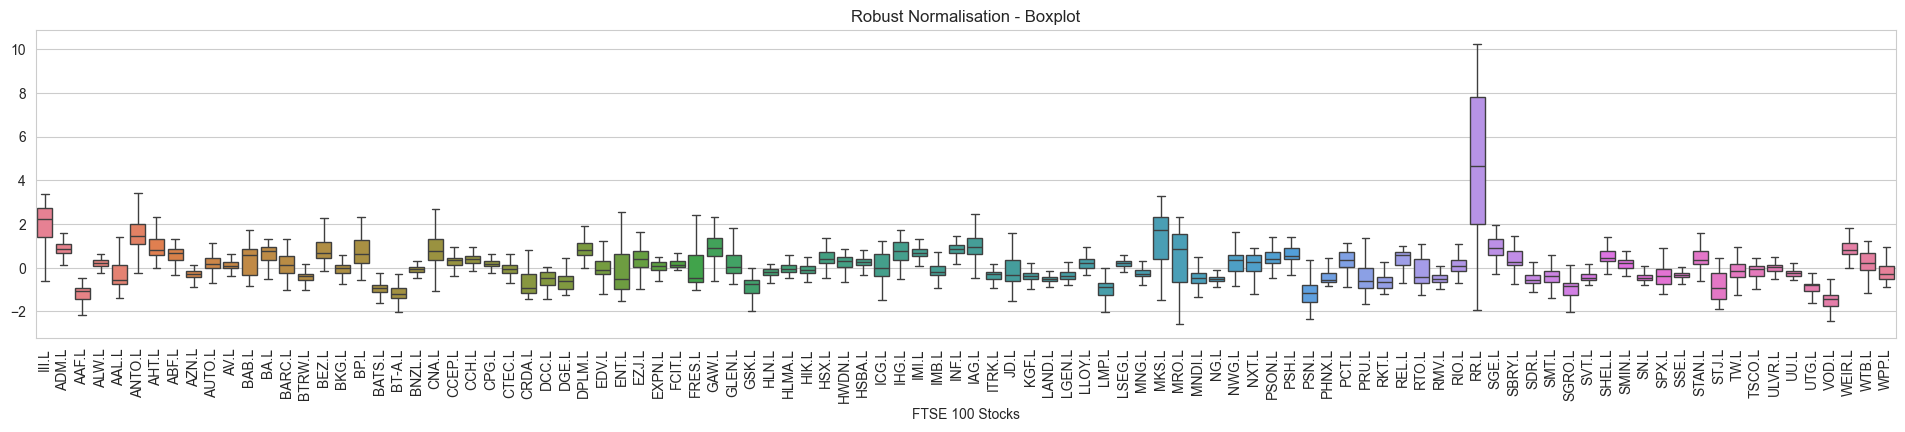

In [20]:
# Step 3: Normalization Techniques
def apply_normalizations(df):
    norm_methods = {}

    # Min-Max Scaling
    norm_methods['MinMax'] = pd.DataFrame(MinMaxScaler().fit_transform(df), index=df.index, columns=df.columns)
    
    # Z-score (StandardScaler)
    norm_methods['ZScore'] = pd.DataFrame(StandardScaler().fit_transform(df), index=df.index, columns=df.columns)
    
    # Decimal Scaling
    def decimal_scaling(df):
        j = np.ceil(np.log10(df.abs().max(axis=1))).replace(0, 1)
        return df.div(10 ** j, axis=0)
    norm_methods['DecimalScaling'] = decimal_scaling(df)
    
    # Log Scale (Shift to avoid log(0))
    norm_methods['LogScale'] = np.log1p(df - df.min().min())
    
    # Robust Scaling
    norm_methods['Robust'] = pd.DataFrame(RobustScaler().fit_transform(df), index=df.index, columns=df.columns)

    return norm_methods

normalized_versions = apply_normalizations(df_pct_diff)

# Plot Histograms and Boxplots
def plot_distributions(normalized_dict):
    for name, norm_df in normalized_dict.items():
        # Histogram
        plt.figure(figsize=(15, 4))
        sns.histplot(norm_df.values.flatten(), bins=100, kde=True)
        plt.title(f'{name} Normalisation - Histogram')
        plt.xlabel("% Difference in Mid-prices")
        plt.show()

        # Boxplot
        plt.figure(figsize=(24, 4))
        sns.boxplot(data=norm_df.T, showfliers=False)
        plt.title(f'{name} Normalisation - Boxplot')
        plt.xticks(rotation=90)
        plt.xlabel("FTSE 100 Stocks")
        plt.show()

plot_distributions(normalized_versions)

In [13]:
# normalized_versions['ZScore'].to_csv('data/zscore_norm_data.csv')
# normalized_versions['DecimalScaling'].to_csv('data/decmal_norm_data.csv')
# normalized_versions['Robust'].to_csv('data/robust.csv')